# Test case comparison

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# Now JAX won't pre-allocate GPU memory

In [2]:
import numpy as np
from jax import jit, vjp, vmap, pmap, random, value_and_grad, nn
import jax
from jax import numpy as jnp
import equinox as eqx
import optax
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field, generate_2D_gridded_src_rec_positions
from hybridoed.oed import *


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

from hybridoed.forward import create_src_field
from hybridoed.oed import *
from hybridoed.utils import *

from functools import partial

from jax.example_libraries import optimizers
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

2025-09-30 14:12:40.811655: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Loading models and defining sources/receivers

(500, 1, 70, 70)


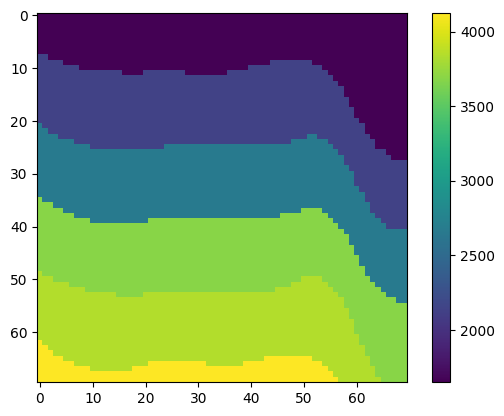

<class 'jaxlib.xla_extension.ArrayImpl'>


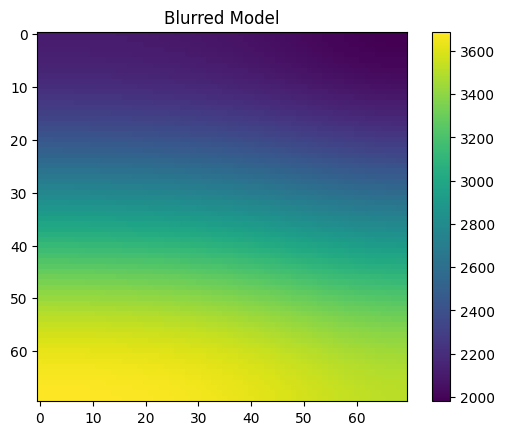

(70, 70)


In [3]:
# Load model

model = jnp.load('model1.npy')


print(model.shape)

model_index = 84

true_model = model[model_index,0,:,:]
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=20)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)

# homogenous model of the velocity avegare

homogenous_model = jnp.ones(true_model.shape) * jnp.mean(true_model)

# plt.imshow(homogenous_model)


In [4]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution
cfl=0.75

# Defining the domain
domain = Domain(N, dx)

source_freq = 200
source_mag = 1.3e-1
# source_mag = 1.3

medium = Medium(domain=domain, sound_speed=true_model, density=1000., pml_size=10)
frequencies = jnp.array([40, 70, 100, 150, 200])  # List of frequencies


# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)
t = time_axis.to_array()
source_mag = source_mag / time_axis.dt

s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t + 100)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 0.5e-2, 1e-2)

# generate a ricker signal instead of a sinusoidal signal

def ricker_wavelet(t, f, t_shift=0.0):
    """
    Generate a Ricker wavelet with a time shift.

    Parameters:
        t (array-like): Time axis (e.g., jax.numpy array).
        f (float): Central frequency of the wavelet.
        t_shift (float): Time shift for the wavelet (default is 0.0).

    Returns:
        jax.numpy.ndarray: Ricker wavelet values at the given time points.
    """
    t_shifted = t - t_shift  # Apply the time shift
    pi2 = (jnp.pi ** 2)
    a = (pi2 * f ** 2) * (t_shifted ** 2)
    wavelet = (1 - 2 * a) * jnp.exp(-a)
    return wavelet


# Parameters
# source_freq = 25.0  # Central frequency in Hz
# t = jnp.linspace(-0.1, 0.2, 1000)  # Time vector in seconds
t_shift = 0.005  # Time shift in seconds

# Generate the Ricker wavelet with time shift
signal = source_mag * ricker_wavelet(t, source_freq, t_shift)

In [5]:
src_coords_list, receiver_coords_list = generate_2D_gridded_src_rec_positions(N=(70, 70), num_sources=5, num_receivers=5)


num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

print(sensors_positions)

(Array([12, 12, 12, 12, 12, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 46, 46,
       46, 46, 46, 57, 57, 57, 57, 57], dtype=int32), Array([12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23, 35, 46, 57, 12, 23,
       35, 46, 57, 12, 23, 35, 46, 57], dtype=int32))


Text(0.5, 1.0, 'Source signals')

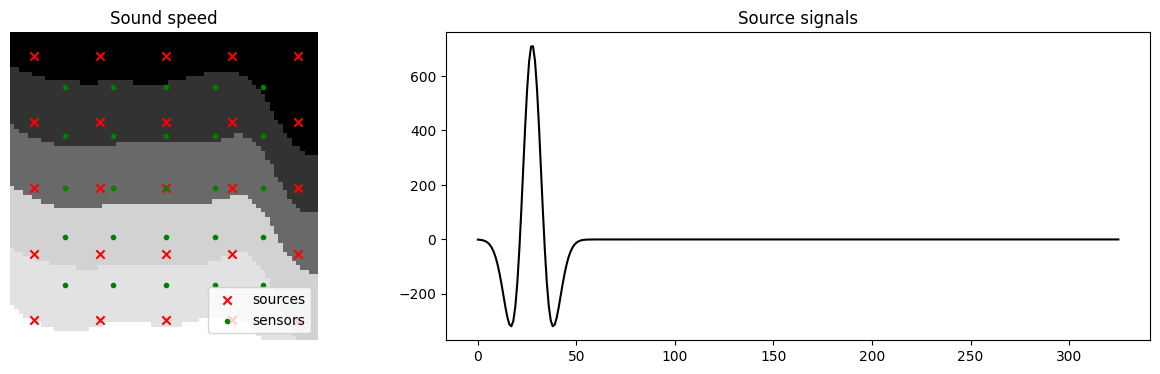

In [6]:
# Show comprehensive simulation setup

fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

## Loading ans stacking the jacobian matrix

In [7]:
jacobians = jnp.load("curvel_jac_model_{}_data_5_5_5.npy".format(model_index))
print(jacobians.shape)
transposed_jacobians = jacobians
print(transposed_jacobians.shape)



(25, 25, 5, 70, 140)
(25, 25, 5, 70, 140)


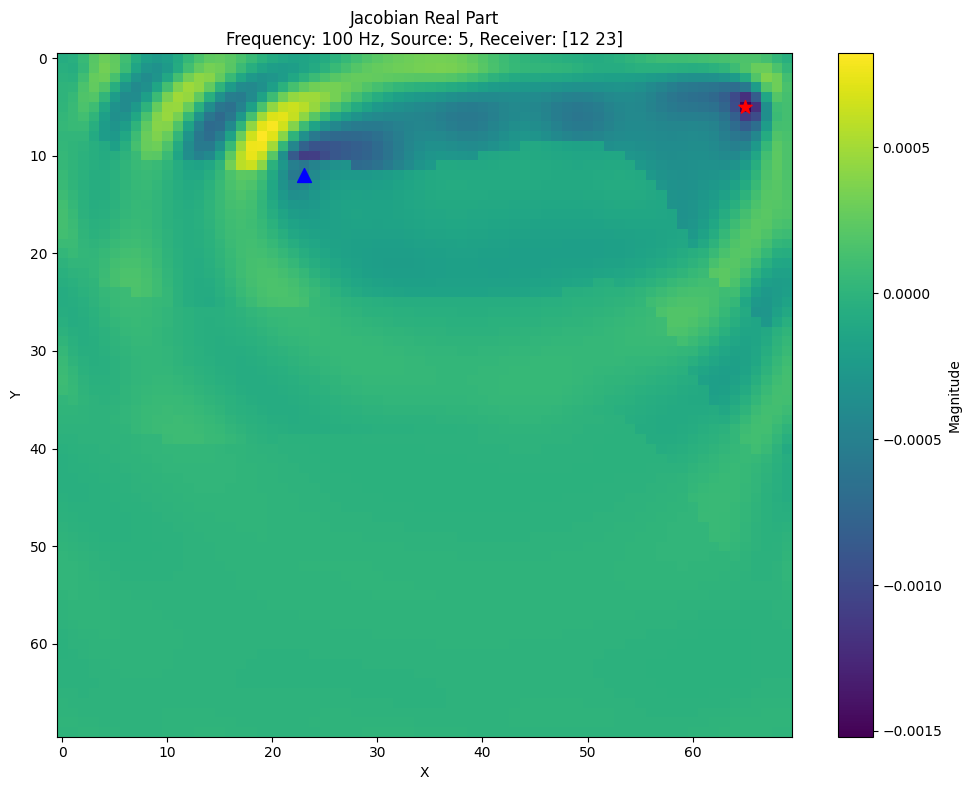

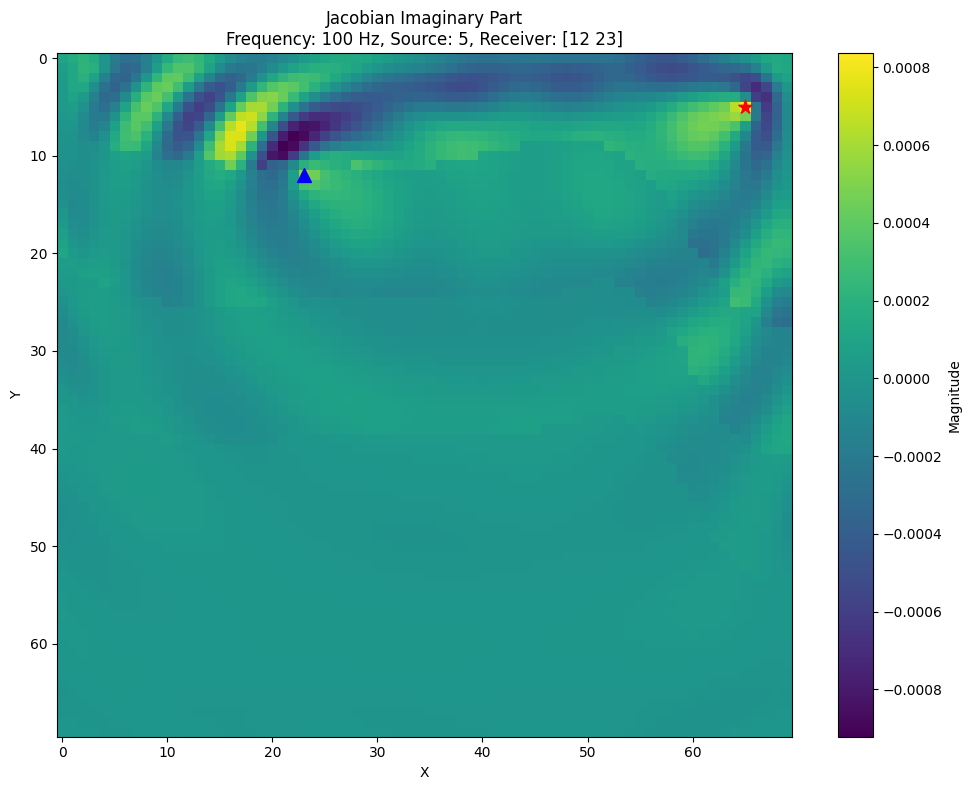

In [8]:
plot_specific_jacobian(transposed_jacobians,frequencies, src_coords_list, receiver_coords_list, source_idx=4, receiver_idx=1, frequency_idx=2, save_path=None)

In [9]:
# 1) Collapse source & receiver dims into one “sample” axis
#    From shape (n_src, n_recv, 70, 140)
#    To   shape (n_src*n_recv, 70, 140)
flat = transposed_jacobians.reshape(-1, 70, 140)

# 2) Split the last axis into real (cols 0–69) and imag (cols 70–139)
#    Resulting shapes: both (n_src*n_recv, 70, 70)
real = flat[:, :, :70]
imag = flat[:, :, 70:]

# 3) Recombine into complex-valued 70×70 matrices
#    Shape stays (n_src*n_recv, 70, 70), dtype=complex128
complex_mats = real + 1j * imag

# 4) Flatten each 70×70 block into a 4900-vector
#    Final shape (n_src*n_recv, 4900)
J_c = complex_mats.reshape(complex_mats.shape[0], -1)

In [10]:
# shape: (n_src, n_recv * n_rows, n_cols) needed for the input of the FCN in section C
stacked_by_src = transposed_jacobians.reshape(
    transposed_jacobians.shape[0],
    transposed_jacobians.shape[1] * transposed_jacobians.shape[2],
    transposed_jacobians.shape[3] * transposed_jacobians.shape[4]
)

## Test case A

Iteration: 0, Sources Selected: 0j
Iteration: 1, Sources Selected: (125+0j)
Iteration: 2, Sources Selected: (250+0j)
Iteration: 3, Sources Selected: (375+0j)
Iteration: 4, Sources Selected: (500+0j)
Iteration: 5, Sources Selected: (625+0j)
Iteration: 6, Sources Selected: (750+0j)
Iteration: 7, Sources Selected: (875+0j)
Iteration: 8, Sources Selected: (1000+0j)
Iteration: 9, Sources Selected: (1125+0j)
Selected rows (indices): [   0    1    2 ... 2497 2498 2499]
mask_history shape: (1250, 1250)


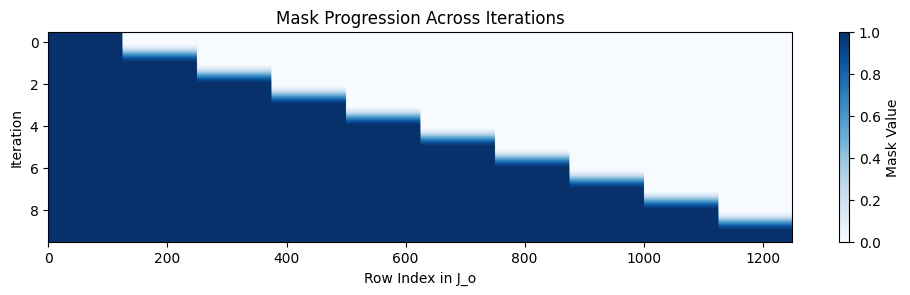

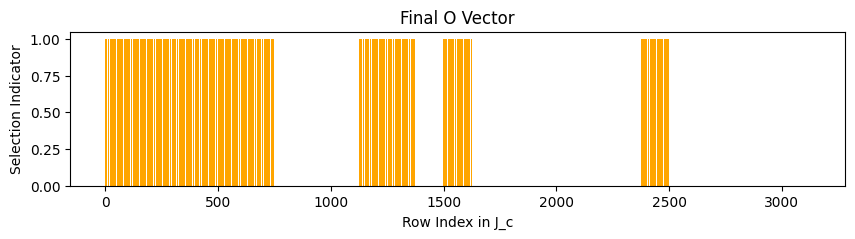

19 0
0 1
4 2
12 3
2 4
10 5
9 6
1 7
3 8
5 9
Ordered list [19, 0, 4, 12, 2, 10, 9, 1, 3, 5]


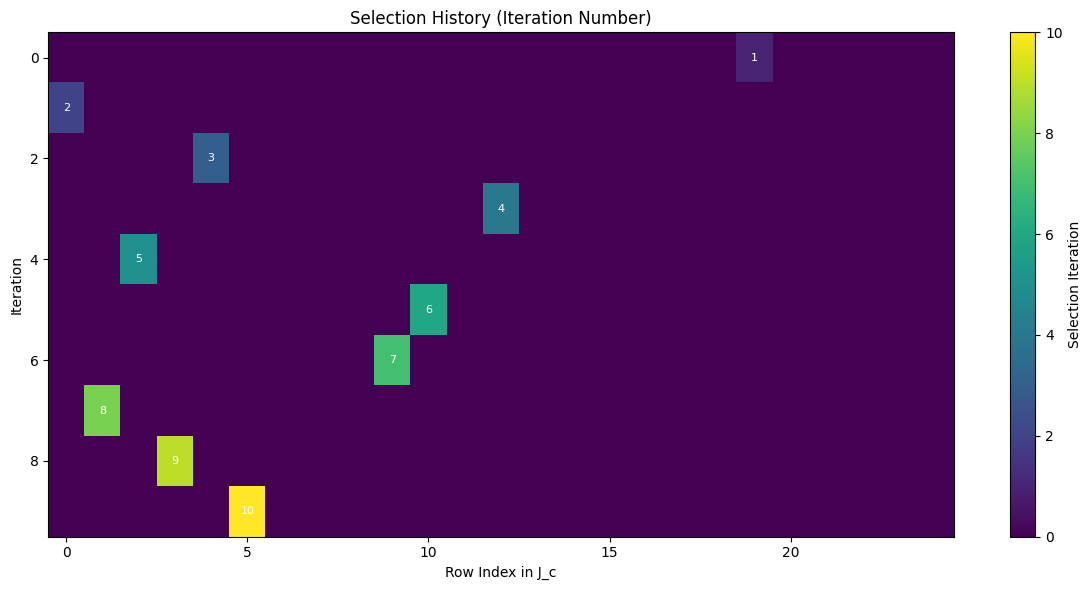

In [11]:
# loaded_data = jnp.load('arrays_complete_1GB.npz')

# # # Access arrays by index
# loaded_arrays = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data))]

# vstack teh arrays
# J_c = (jnp.vstack(loaded_arrays))
# print(J_c.shape)


# Run the algorithm with logging
num_rows = 10
# threshold = 10e-10 # MODJO criterion
# threshold = 1e-10 curvel_5_5_5
threshold = 1e-10

J_o_final, O_final, mask_history, criterion_log = iterative_selection_no_reselection(J_c, num_rows, n_freq=5, n_receivers=25,selection_mode="block", threshold=threshold)
# J_o_final, O_final, mask_history, criterion_log, augmented_J_o_history = iterative_selection_with_augmented_tracking(J_c, num_rows, threshold)

# Extract the selected row indices
selected_rows = jnp.where(O_final.flatten() == 1)[0]

# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape, "augmented_J_o_history shape", augmented_J_o_history.shape)  
# print("J_o shape", J_o_final.shape,"J_c shape", J_c.shape)

# Verify the results
# print("Expected significant rows (indices):", jnp.sort(expected_rows))
print("Selected rows (indices):", selected_rows)

# Check if all expected rows are in the selected rows
# all_expected_selected = jnp.all(jnp.isin(expected_rows, selected_rows))
# print("Are all expected rows among the selected rows?", all_expected_selected)

print('mask_history shape:', mask_history.shape)

# Plot the mask history
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(jnp.real(mask_history[:num_rows,:]), aspect='auto', cmap='Blues')
plt.colorbar(label="Mask Value")
plt.xlabel("Row Index in J_o")
plt.ylabel("Iteration")
plt.title("Mask Progression Across Iterations")

# Plot O_final
plt.figure(figsize=(10, 2))
plt.bar(jnp.arange(len(O_final)), jnp.real(O_final.flatten()), color='orange')
plt.xlabel("Row Index in J_c")
plt.ylabel("Selection Indicator")
plt.title("Final O Vector")
plt.show()

# # Plot the criterion values
# plt.subplot(2, 1, 2)
# plt.imshow(criterion_log, aspect='auto', cmap='viridis')
# plt.colorbar(label="Criterion Improvement")
# plt.xlabel("Row Index in J_c")
# plt.ylabel("Iteration")
# plt.title("Criterion Improvement Across Iterations")
# plt.tight_layout()
# plt.show()

# Plot the progression of active_J_o
# plt.figure(figsize=(12, 6))
# for i in range(active_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(active_J_o_history[i], aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")

# plt.tight_layout()
# plt.show()

# Plot the progression of augmented_J_o
# plt.figure(figsize=(12, 12))
# for i in range(augmented_J_o_history.shape[0]):
#     plt.subplot(num_rows // 2 + 1, 2, i + 1)
#     plt.imshow(jnp.real(augmented_J_o_history[i]), aspect='auto', cmap='viridis')
#     plt.colorbar(label="Value")
#     plt.title(f"Iteration {i + 1}")
#     # plt.xlabel("Features")
#     plt.ylabel("Rows in J_o")
# plt.suptitle("Progression of Augmented J_o Across Iterations")
# plt.tight_layout()
# plt.show()


# Create a matrix to record the selection history
selection_history = jnp.zeros_like(criterion_log, dtype=jnp.complex64)

# Populate the selection history matrix with iteration numbers
selected_rows = []
for iteration in range(criterion_log.shape[0]):
    best_row_idx = jnp.argmax(jnp.real(criterion_log[iteration]))  # Get the selected row for this iteration
    selected_rows.append(best_row_idx)
    selection_history = selection_history.at[iteration, best_row_idx].set(iteration + 1)

# Plot the selection history heatmap
plt.figure(figsize=(12, 6))

# Heatmap of selection history
plt.imshow(jnp.real(selection_history), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label="Selection Iteration")
plt.xlabel("Row Index in J_c")
plt.ylabel("Iteration")
plt.title("Selection History (Iteration Number)")

# Annotate the heatmap with iteration numbers
ordered_list = []
for iteration, row_idx in enumerate(selected_rows):
    plt.text(row_idx, iteration, str(iteration + 1), color="white", ha="center", va="center", fontsize=8)
    print(row_idx, iteration)
    ordered_list.append(row_idx.item())
print("Ordered list", ordered_list)
plt.tight_layout()
plt.show()


In [12]:
best_sources_A = jnp.array(ordered_list)

In [13]:
best_sources_A

Array([19,  0,  4, 12,  2, 10,  9,  1,  3,  5], dtype=int32)

## Test case C

In [14]:
params = {
    "criterion_threshold": 1e-10,
    "regularisation_loss": 0.0,
    "norm_loss": 0.0,
    "top_k_loss": 0.0,
    "differentiable_mask_sharpness": 10.0,
    "number_of_opti_sources":10,
    "hidden_size": 56,
    "num_hidden_layers": 3,
    "learning_rate": 1e-3,
    "num_iterations": 20,
    "print_gradients": False,
}

In [15]:
criterion_threshold = params["criterion_threshold"]

C_sources_1e_3 = [] 
for array in stacked_by_src:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=criterion_threshold))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

In [16]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    activations: list

    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

def top_k_regularization(soft_mask, k=10):
    top_k_values = jax.lax.top_k(soft_mask, k)[0]
    penalty = jnp.sum(soft_mask) - jnp.sum(top_k_values)
    return penalty

# Differentiable Loss Function
def differentiable_loss_fn(model, x, matrix, criterion_threshold ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    
    

    multiplier = matrix.shape[0] // soft_mask.shape[0]
    soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows

    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask
    norm_loss = jnp.linalg.norm(soft_mask, ord=1)
    top_k_loss = top_k_regularization(soft_mask, k=params["number_of_opti_sources"])

    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)

    return -(singular_loss) + params["regularisation_loss"]*regularization_loss + params["norm_loss"]*norm_loss + params["top_k_loss"]*top_k_loss



In [17]:
# Example Usage
key = jax.random.PRNGKey(42)
input_size = C_sources_1e_3.shape[0]
hidden_size = params["hidden_size"]
num_hidden_layers = params["num_hidden_layers"]
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)

print("Model:", model)

# matrix = jax.random.normal(key, (100, 50))  # Matrix with 100 rows and 50 columns
# matrix = complex_stack_complete_2D
# matrix = J_c
# x = jax.random.normal(key, (input_size,))  # Input to the network
x = C_sources_1e_3
# x = (x - jnp.mean(x)) / jnp.std(x)
x = (x - jnp.min(x)) / (jnp.max(x) - jnp.min(x))

Model: FullyConnectedNN(
  layers=[
    Linear(
      weight=f32[56,25],
      bias=f32[56],
      in_features=25,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[25,56],
      bias=f32[25],
      in_features=56,
      out_features=25,
      use_bias=True
    )
  ],
  activations=[
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function sigmoid>
  ]
)


Step 0, Loss: -1674.317626953125
Step 1, Loss: -1677.887451171875
Step 2, Loss: -1681.260009765625
Step 3, Loss: -1684.54541015625
Step 4, Loss: -1687.82373046875
Step 5, Loss: -1691.14111328125
Step 6, Loss: -1694.520751953125
Step 7, Loss: -1697.964599609375
Step 8, Loss: -1701.46044921875
Step 9, Loss: -1704.983642578125
Step 10, Loss: -1708.4993896484375
Step 11, Loss: -1711.963623046875
Step 12, Loss: -1715.32666015625
Step 13, Loss: -1718.5423583984375
Step 14, Loss: -1721.564697265625
Step 15, Loss: -1724.360107421875
Step 16, Loss: -1726.904541015625
Step 17, Loss: -1729.185546875
Step 18, Loss: -1731.203857421875
Step 19, Loss: -1732.9700927734375


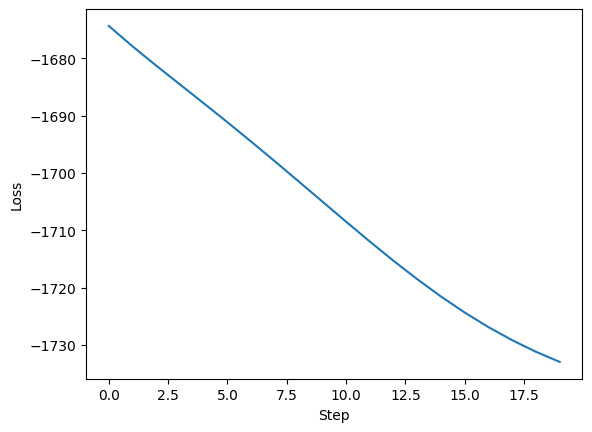

In [18]:
def train_step(model, matrix, criterion_threshold, optimizer, opt_state, x, logs):
    # Compute loss and gradients
    loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
    loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=criterion_threshold, sharpness=params["differentiable_mask_sharpness"], mask_penalty=1.0)
    
    if params["print_gradients"]:  
        jax.tree_util.tree_map(lambda g: print("Gradient shape:", g.shape, "Gradient values:", g), grads)
        jax.tree_util.tree_map(lambda g: print(f"Gradient shape: {g.shape}, Min: {jnp.min(g)}, Max: {jnp.max(g)}, Mean: {jnp.mean(g)}"), grads)

    # Update optimizer state and model
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)

    # Log the network output (predicted probabilities)
    probabilities = model(x)  # Network output
    logs["probabilities"].append(probabilities)

    # Log the mask M
    soft_mask = differentiable_mask(probabilities, sharpness=params["differentiable_mask_sharpness"])  # Differentiable mask
    logs["masks"].append(soft_mask)

    return loss, model, opt_state


# Initialize the model and optimizer
# key = jax.random.PRNGKey(42)
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)
optimizer = optax.adamw(params["learning_rate"])  # Adam optimizer
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state
initial_predictions = model(x)  # Initial predictions

# Training loop
num_steps = params["num_iterations"]
losses = []
logs = {"probabilities": [], "masks": []}
for step in range(num_steps):
    loss, model, opt_state = train_step(model, J_c, criterion_threshold, optimizer, opt_state, x, logs)
    losses.append(loss)

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


Step 0: Probabilities: [0.56476575 0.51396215 0.48335698 0.5316987  0.5035132  0.5123491
 0.49637344 0.49434108 0.50192934 0.5265536  0.49912784 0.4906692
 0.5123712  0.571111   0.5425303  0.49912345 0.5130668  0.4783451
 0.50450367 0.5137739  0.4732115  0.47599465 0.5303978  0.5014571
 0.47493437]
Step 0: Mask: [0.6564824  0.5348488  0.45848823 0.5785898  0.50878215 0.53083366
 0.49093464 0.48585644 0.5048232  0.5659966  0.49781954 0.47668993
 0.53088856 0.6706464  0.60475147 0.4978086  0.53262067 0.4460733
 0.5112573  0.53438044 0.43342638 0.4402732  0.5754146  0.5036427
 0.437662  ]
Step 1: Probabilities: [0.5657646  0.52250105 0.49022326 0.5432993  0.5114057  0.52083886
 0.4988582  0.5019349  0.51055115 0.53639877 0.5078452  0.49720392
 0.51316184 0.5767073  0.54556423 0.5047709  0.520643   0.48713398
 0.51563156 0.5221158  0.48281014 0.47752768 0.5419077  0.5054649
 0.4843759 ]
Step 1: Mask: [0.65873146 0.55601645 0.47557756 0.60658824 0.5284834  0.5519094
 0.4971456  0.50483704 0

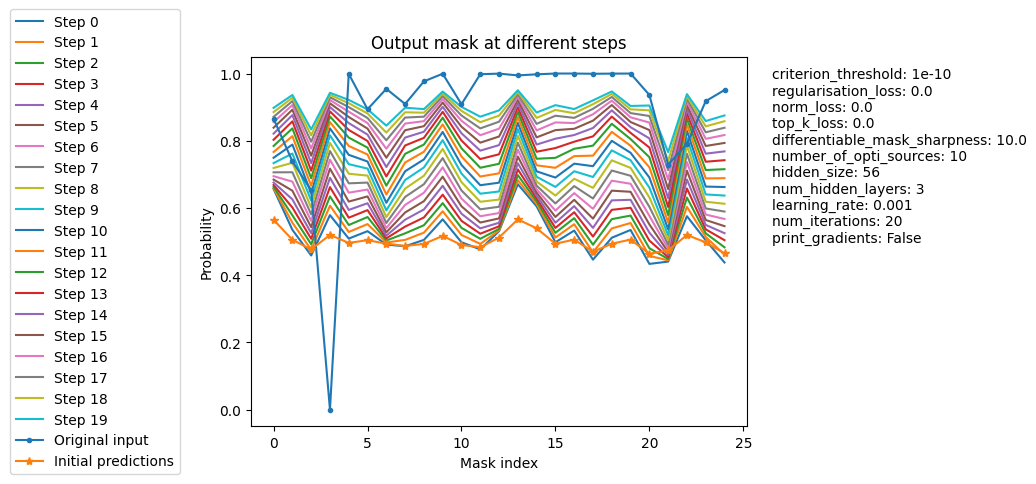

In [19]:
# Print the first few steps for inspection
for i, (probs, mask) in enumerate(zip(logs["probabilities"], logs["masks"])):
    print(f"Step {i}: Probabilities: {probs}")
    print(f"Step {i}: Mask: {mask}")
    if i > 5:  # Limit to first few steps for readability
        break

# Example: Plot the first mask at different training steps
steps_to_plot = [i for i in range(num_steps)]  # Select steps to visualize
plt.figure()

for step in steps_to_plot:
    plt.title(f"Output mask at different steps")
    plt.plot(logs["masks"][step], label=f"Step {step}")
    # plt.colorbar(label="Mask Values")
    plt.xlabel("Mask index")
    plt.ylabel("Probability")

plt.plot(x, ".-", label="Original input")
plt.plot(initial_predictions,"*-", label="Initial predictions")
# put the legend outside of the graph, to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.5, 0.5))

# add the params dictionary to the plot, on the right, one key per line
plt.text(1.05, 0.5, '\n'.join([f"{key}: {value}" for key, value in params.items()]), transform=plt.gca().transAxes)

plt.show()

In [20]:
final_mask = logs["masks"][-1]
best_sources_C = jnp.argsort(final_mask)[-params["number_of_opti_sources"]:]
print("best source index", best_sources_C)

best source index [20 15 17  4  1 22  3  9 18 13]


## Test case BD

In [21]:
# jacobian_test_case_BD = jnp.load("curvel_jac_model_{}_data_test_case_BD_4_sources_v2.npy".format(model_index))
# jacobian_test_case_BD = jnp.load("curvel_jac_model_{}_data_test_case_BD_dataloss_10_sources.npy".format(model_index))
jacobian_test_case_BD = jnp.load("curvel_jac_model_{}_data_test_case_BD.npy".format(model_index))


transposed_jacobian_test_case_BD = jacobian_test_case_BD
print(jacobian_test_case_BD.shape)

(10, 25, 5, 70, 140)


In [22]:
# — Step 2: build the global J_c —

# a) collapse source & receiver dims in one go:
#    from (n_src, n_recv, 70, 140)
#    to   (n_src * n_recv, 70, 140)
flat = transposed_jacobian_test_case_BD.reshape(-1, 70, 140)

# b) split real vs imag along the last axis
real = flat[:, :, :70]     # (n_src*n_recv, 70, 70)
imag = flat[:, :, 70:]     # (n_src*n_recv, 70, 70)

# c) recombine into complex 70×70
complex_mats = real + 1j * imag

# d) flatten each 70×70 into a 4900-vector, giving (n_samples, 4900)
J_c_BD = complex_mats.reshape(complex_mats.shape[0], -1)

# add zeros rows to mathc the sshape of J_c
# J_c_BD = jnp.concatenate((J_c_BD, jnp.zeros((J_c_BD.shape[0], 4900))), axis=0)

In [23]:
print("J_c_BD shape", J_c_BD.shape)

J_c_BD shape (1250, 4900)


Loss test BD 901.33606
Loss test comprehensive 1746.0256


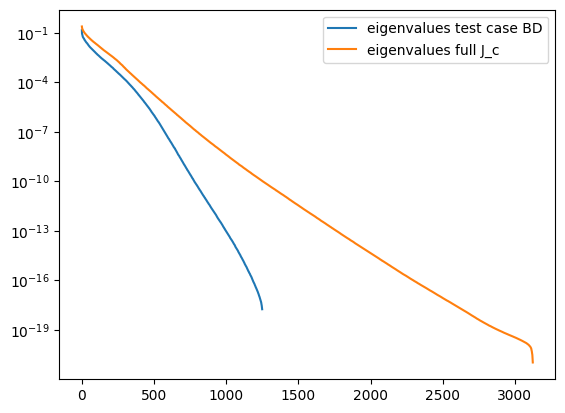

In [24]:
eigen_test = jnp.linalg.svdvals(J_c_BD)
eigen_test_A = jnp.linalg.svdvals(J_c)
plt.semilogy(eigen_test**2, label="eigenvalues test case BD")
plt.semilogy(eigen_test_A**2, label="eigenvalues full J_c")
plt.legend()
plt.plot()
loss_test = eigenvalue_criterion(J_c_BD, threshold=threshold)
print("Loss test BD", loss_test)
loss_test_comp = eigenvalue_criterion(J_c, threshold=threshold)
print("Loss test comprehensive", loss_test_comp)

## Final loss calculation


In [25]:
def process_matrix_with_mask(matrix, best_source_index, final_mask, eigenvalue_criterion, threshold):
    """
    Apply a mask to the matrix based on the best source index and compute the singular loss.

    Args:
        matrix (jnp.ndarray): Input matrix to be processed.
        best_source_index (int): Index of the best source.
        final_mask (jnp.ndarray): Initial mask array.
        eigenvalue_criterion (callable): Function to compute the eigenvalue-based loss.
        threshold (float): Threshold for the eigenvalue criterion.

    Returns:
        float: Singular loss computed for the masked matrix.
        jnp.ndarray: Final mask applied to the matrix.
    """
    print("Best source index:", best_source_index)
    # print("MAtrix inout shaoe:", matrix.shape)

    # Create a mask with the best sources
    mask_best_source = jnp.zeros_like(final_mask)
    mask_best_source = mask_best_source.at[best_source_index].set(1.0)
    print(mask_best_source, "sum:", jnp.sum(mask_best_source))

    # Repeat the mask to match the matrix dimensions
    multiplier = matrix.shape[0] // mask_best_source.shape[0]
    full_mask = jnp.repeat(mask_best_source, multiplier, axis=0)

    # Apply the mask to the matrix
    weighted_matrix = full_mask[:, None] * matrix
    # print("Weighted matrix shape before removing zero rows:", weighted_matrix.shape)

    # remove the rows with all zeros
    weighted_matrix = weighted_matrix[jnp.any(weighted_matrix != 0, axis=1)]
    print("Weighted matrix shape:", weighted_matrix.shape)

    # Compute the singular loss
    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=threshold)
    eigenvalues = jnp.sort(jnp.linalg.svdvals(weighted_matrix)**2)[::-1]

    print("Singular loss:", singular_loss)

    return singular_loss, full_mask, eigenvalues, weighted_matrix

In [26]:
final_loss_A, final_mask_A, eigenvlues_A, weigthed_matrix = process_matrix_with_mask(J_c, best_sources_A, jnp.zeros(num_sources) , eigenvalue_criterion, threshold=criterion_threshold)

# best_source_A = jnp.array([21 ,20, 22, 23, 24, 16, 15, 17, 18, 19])

Best source index: [19  0  4 12  2 10  9  1  3  5]
[1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0.] sum: 10.0
Weighted matrix shape: (1250, 4900)
Singular loss: 891.4142


In [27]:
final_loss_C, final_mask_C, eigenvlues_C,_ = process_matrix_with_mask(J_c, best_sources_C, logs["masks"][-1], eigenvalue_criterion, threshold=criterion_threshold)

Best source index: [20 15 17  4  1 22  3  9 18 13]
[0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0.] sum: 10.0
Weighted matrix shape: (1250, 4900)
Singular loss: 881.64404


In [28]:
# best_sources_D = jnp.array([11  ,5, 15, 17 , 0 , 9 , 8 , 4 ,12 ,13]) # model 84
# best_sources_D = jnp.array([19,  9 , 5 , 3, 13, 22, 16, 24 , 0 ,14]) # model 84 dataloss
# best_sources_D = jnp.array( [ 5, 18, 15,  9 ,10 , 4 , 8, 17, 12 ,13]) # model 7 modelloss
# best_sources_D = jnp.array([ 9 ,23,  1, 22,  6,  3, 16,  2,  0, 24]) # model 84 modelloss probabilities applied on data

# all of he above is bullshit


# best_sources_D = jnp.array([ 8 ,12 ,17 , 4 ,22 ,23 , 1 ,14 ,21 , 2]) # 200 fwi iterations model 7
# best_sources_D = jnp.array([24 ,19 ,21, 18 , 6, 23 ,20 ,11 , 2 ,22]) # 100 fwi iterations model 7
best_sources_D = jnp.array([ 4 ,19 , 1 , 6 , 0 ,20 , 5 ,18 ,22 , 2])[-params["number_of_opti_sources"]:] # 100 fwi iterations model 84
# best_sources_D = jnp.array([12 , 5,  0 , 2,  1,  6, 15, 11  7 22]) # 100 fwi iterations model 84
# best_sources_D = jnp.array([17,  7 ,14,  6, 24, 18, 20 , 1 ,11 ,21])
final_loss_D, final_mask_D, eigenvlues_D,_ = process_matrix_with_mask(J_c, best_sources_D[-params["number_of_opti_sources"]:], jnp.zeros(num_sources), eigenvalue_criterion, threshold=criterion_threshold)

Best source index: [ 4 19  1  6  0 20  5 18 22  2]
[1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0.] sum: 10.0
Weighted matrix shape: (1250, 4900)
Singular loss: 886.07446


In [29]:
final_loss_BD, final_mask_BD, eigenvlues_BD,_ = process_matrix_with_mask(J_c_BD, jnp.array([i for i in range(10)]), jnp.zeros(10), eigenvalue_criterion, threshold=criterion_threshold)

Best source index: [0 1 2 3 4 5 6 7 8 9]


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] sum: 10.0
Weighted matrix shape: (1250, 4900)
Singular loss: 901.33606


In [30]:
# final_loss_comprehensive = eigenvalue_criterion(J_c, threshold=params["criterion_threshold"])
# eigenvlues_comprehensive = jnp.sort(jnp.linalg.svdvals(J_c)**2)[::-1]
# print("Comprehensive loss:", final_loss_comprehensive)

In [31]:
# plot all the eigenvalues
# plt.figure()
# plt.semilogy(eigenvlues_A, label="Best Sources A")
# plt.semilogy(eigenvlues_C, label="Best Sources C")
# plt.semilogy(eigenvlues_D, label="Best Sources D")
# plt.semilogy(eigenvlues_BD, label="Best Sources BD")
# plt.semilogy(eigenvlues_comprehensive, label="Comprehensive")
# plt.axhline(y=criterion_threshold, color='r', linestyle='--', label="Threshold")
# plt.xlim(725, 800)
# plt.ylim(0.8e-10, 1.2e-10)
# plt.legend()
# plt.xlabel("Eigenvalue Index")
# plt.ylabel("Eigenvalue")
# plt.title("Eigenvalues of the Reduced Matrix")
# plt.show()

# print(eigenvlues_comprehensive.shape)


In [32]:
# # random selection of sources

# number_of_random_realisations = 100
# loss_random = []

# for i in range(number_of_random_realisations):
#     best_source_random = jnp.array(np.random.choice(jnp.arange(0, 25), params["number_of_opti_sources"], replace=False))

#     # mask_best_source_A = jnp.zeros_like(final_mask)
#     # mask_best_source_A = mask_best_source_A.at[best_source_A].set(1.0)
#     # if jnp.sum(mask_best_source_A) != params["number_of_opti_sources"]:
#     #     print("Error in mask")
#     #     break

#     # multiplier = J_c.shape[0] // mask_best_source_A.shape[0]
#     # full_mask = jnp.repeat(mask_best_source_A, multiplier, axis=0)

#     # weighted_matrix = full_mask[:, None] * J_c_BD  # Apply mask to matrix rows
#     # # print("Weighted matrix shape:", weighted_matrix.shape)

#     # # remove the rows with all zeros
#     # weighted_matrix = weighted_matrix[jnp.any(weighted_matrix != 0, axis=1)]

#     # singular_loss = eigenvalue_criterion(weighted_matrix, threshold=params["criterion_threshold"])
#     final_loss_A, final_mask_A, eigenvlues_A, weigthed_matrix = process_matrix_with_mask(J_c, best_source_random, jnp.zeros(num_sources) , eigenvalue_criterion, threshold=criterion_threshold)
    
#     loss_random.append(final_loss_A)


# loss_random = jnp.array(loss_random)

# plt.figure()
# plt.hist(loss_random, bins=20)
# plt.show()


# print("Mean loss:", jnp.mean(loss_random))
# print("Std loss:", jnp.std(loss_random))
# print("Min loss:", jnp.min(loss_random))
# print("Max loss:", jnp.max(loss_random))
# print("Median loss:", jnp.median(loss_random))

## Inversion

In [33]:

# Case B
test_case_B = False
test_case_BD = True
test_case_A = False
test_case_C = False
test_case_D = False
file_name = ""

if test_case_B:
    source_trajectories = jnp.load('source_trajectories.npy')
    source_positions = (source_trajectories[-1][:,0], source_trajectories[-1][:,1])
    # transform every values in source_positions to integers
    source_positions = (source_positions[0].astype(int), source_positions[1].astype(int))
    # add 10 more sources to the source positions to reach 20 sources
    # source_positions = (jnp.hstack([source_positions[0], jnp.repeat(0,10)]), jnp.hstack([source_positions[1], jnp.repeat(0,10)]))
    file_name = "test_case_B"
    

elif test_case_BD:
    
    # sources_BD = jnp.array([[14.382133 ,  2.1       ],
    # [ 5.5706286, 35.721813 ],
    # [ 2.1     ,   60.984917 ],
    # [17.679596 , 47.96921  ],
    # [28.95357 ,   7.5863786],
    # [30.99244 ,  62.78967  ],
    # [48.796   ,  20.815329 ],
    # [63.72263  ,  7.250306 ],
    # [66.1188   , 29.993034 ],
    # [62.13771 ,  60.35725  ]])

    # L2 optimized
    sources_BD = jnp.array([[12.744534 , 22.706297 ],
                [33.706535 , 15.072362 ],
                [63.959553 ,  2.3975747],
                [26.548985 , 25.50571  ],
                [30.431902 , 32.970486 ],
                [56.86398  , 39.30091  ],
                [26.317326 , 48.376205 ],
                [23.04498  , 43.249546 ],
                [59.533405 , 58.90068  ]])
    
    # data outer loss
    # sources_BD = jnp.array([[16.38444,   13.950541 ],
    #             [ 2.        ,59.450993 ],
    #             [26.254986  ,53.824955 ],
    #             [10.937537  ,38.512135 ],
    #             [ 9.709988   ,2.       ],
    #             [28.69385   ,47.37943  ],
    #             [45.797436  , 7.1048193],
    #             [62.569813  ,16.945185 ],
    #             [58.80939   ,46.854218 ],
    #             [58.99601   ,47.43238  ]])

    # sources_BD = jnp.array([[ 8.3999405 ,25.671824 ],
    #                         [ 8.582172 , 49.42382  ],
    #                         [60.64357  , 18.00311  ],
    #                         [54.8574   , 44.141323 ]])

    # sources_BD = jnp.array([[ 7.144508 ,35.93933 ],
    #                         [17.445248 ,50.379555],
    #                         [60.531483 ,19.173174],
    #                         [62.754444 ,29.483873]])


    src_coords_list = sources_BD.astype(jnp.int32)
    source_positions = (src_coords_list[:,0],src_coords_list[:,1])
    file_name = "test_case_BD"
    singular_loss, final_mask_BD, eigenvlues_BD,_ = process_matrix_with_mask(J_c_BD, jnp.array([i for i in range(10)]), jnp.zeros(10), eigenvalue_criterion, threshold=criterion_threshold)
    


    

elif test_case_A:
    filtered_x = source_positions[0][best_sources_A]
    filtered_y = source_positions[1][best_sources_A]
    source_positions = (filtered_x, filtered_y)
    source_index = jnp.array(best_sources_A)
    file_name = "test_case_A"
    singular_loss, final_mask_A, eigenvlues_A, weigthed_matrix = process_matrix_with_mask(J_c, best_sources_A, jnp.zeros(num_sources) , eigenvalue_criterion, threshold=criterion_threshold)

elif test_case_C:
    filtered_x = source_positions[0][best_sources_C]
    filtered_y = source_positions[1][best_sources_C]
    source_positions = (filtered_x, filtered_y)
    source_index = jnp.array(best_sources_C)
    file_name = "test_case_C"
    singular_loss, final_mask_C, eigenvlues_C,_ = process_matrix_with_mask(J_c, best_sources_C, logs["masks"][-1], eigenvalue_criterion, threshold=criterion_threshold)

elif test_case_D:
    filtered_x = source_positions[0][best_sources_D]
    filtered_y = source_positions[1][best_sources_D]
    source_positions = (filtered_x, filtered_y)
    source_index = jnp.array(best_sources_D)
    file_name = "test_case_D"
    best_sources_D = jnp.array([ 4 ,19 , 1 , 6 , 0 ,20 , 5 ,18 ,22 , 2])[-params["number_of_opti_sources"]:] # 100 fwi iterations model 84

    singular_loss, final_mask_D, eigenvlues_D,_ = process_matrix_with_mask(J_c, best_sources_D[-params["number_of_opti_sources"]:], jnp.zeros(num_sources), eigenvalue_criterion, threshold=criterion_threshold)

else:
    print("No test case selected. Set one of the test_case_* variables to True. Fallback to default case, comprehensive.")
    # default case all sources are used
    source_positions = (src_coords_list[:,0], src_coords_list[:,1])
    source_index = jnp.arange(0, num_sources)
    file_name = "comprehensive_case"
    singular_loss, final_mask, eigenvlues, weigthed_matrix = process_matrix_with_mask(J_c, jnp.arange(0, num_sources), jnp.zeros(num_sources) , eigenvalue_criterion, threshold=criterion_threshold)




print(source_positions)
num_sources = len(source_positions[0])
print("Number of sources:", num_sources)

Best source index: [0 1 2 3 4 5 6 7 8 9]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] sum: 10.0
Weighted matrix shape: (1250, 4900)
Singular loss: 901.33606
(Array([12, 33, 63, 26, 30, 56, 26, 23, 59], dtype=int32), Array([22, 15,  2, 25, 32, 39, 48, 43, 58], dtype=int32))
Number of sources: 9


In [34]:
src_signal = jnp.stack([signal])

# We can compile the entire function! All the constructors
# that don't depend on the inputs will be statically compiled
# and run only once.
@jit
def single_source_simulation(sound_speed, source_num):

        

    # if isinstance(source_num, int):
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
        # print("x, y","int", x,y)

    # else:
    #     x = [source_num[0].astype(jnp.int32)]
    #     y = [source_num[1].astype(jnp.int32)]
    #     print("x, y","array", x,y)
        
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=10)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]

<class 'int'>


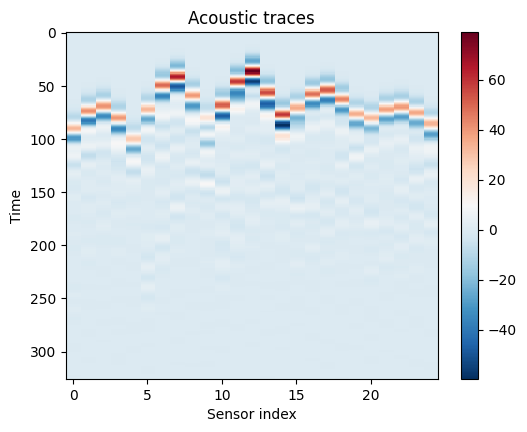

In [35]:
print(type(num_sources//2))
# print(len(source_trajectories[-1][0]))
p = single_source_simulation(medium.sound_speed, num_sources // 2)
# p = single_source_simulation(medium.sound_speed, source_trajectories[-1][0])
# 
# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", interpolation="nearest", aspect="auto"
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

In [36]:

# mask = circ_mask(domain.N, 80, (128, 128))
# mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

# mask the pixel of the source and receviers defined above
mask = jnp.ones(domain.N)

mask = mask.at[sensors_positions[0], sensors_positions[1]].set(0.0)




def get_sound_speed(params):
    return params + compose(params)(nn.sigmoid) * mask

# initial model is the blurred model
params = blurred_model
# params = homogenous_model
# params = medium.sound_speed * 0.1 + 
params

array([[2112.9797, 2112.9204, 2112.8018, ..., 1980.7213, 1980.1364,
        1979.8428],
       [2114.6707, 2114.6113, 2114.4927, ..., 1982.1687, 1981.5826,
        1981.2886],
       [2118.0486, 2117.989 , 2117.87  , ..., 1985.0613, 1984.473 ,
        1984.1777],
       ...,
       [3684.9197, 3684.87  , 3684.771 , ..., 3509.472 , 3508.6555,
        3508.2458],
       [3687.7908, 3687.7415, 3687.6423, ..., 3512.7   , 3511.8853,
        3511.4763],
       [3689.2268, 3689.1775, 3689.0786, ..., 3514.3157, 3513.5017,
        3513.0933]], shape=(70, 70), dtype=float32)

In [37]:
from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

def hilbert_transf(signal, noise=0.2):
    x = jnp.abs(analytic_signal(signal))
    return x

def loss_func(params, source_num):
    c0 = get_sound_speed(params)
    p = single_source_simulation(c0, source_num)
    data = p_data[source_num]
    # return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)
    # L2 loss
    return jnp.mean((p - data) ** 2)

loss_with_grad = value_and_grad(loss_func, argnums=0)

# def loss_func_multi(params, source_nums):
#     """
#     Compute the loss for multiple sources by averaging their individual losses.
#     """
#     c0 = get_sound_speed(params)
#     total_loss = 0.0
#     for src_num in source_nums:
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         total_loss += jnp.mean((p - data) ** 2)  # L2 loss
#     return total_loss / len(source_nums)  # Average loss over sources

# loss_with_grad_multi = value_and_grad(loss_func_multi, argnums=0)

In [38]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

Size of data [Source idx, Time, Sensor idx]: (9, 326, 25)


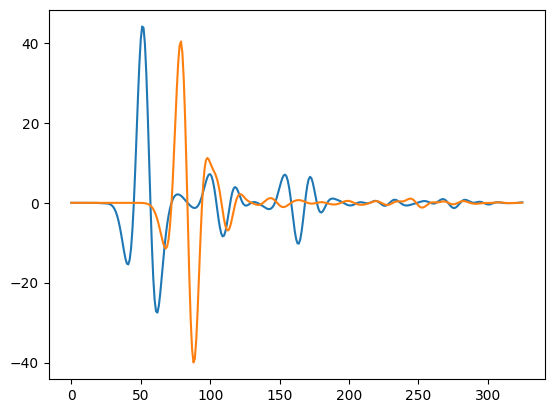

In [39]:
plt.plot(p_data[0, :, 0])
plt.plot(p_data[1, :, 1])
plt.show()

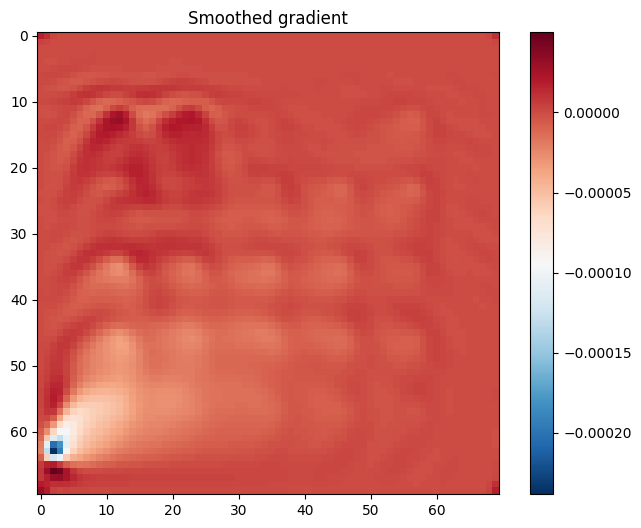

In [40]:
from jaxdf.operators import compose

def smooth_fun(gradient):
    # x = gradient.on_grid[..., 0]
    x = gradient
    for _ in range(1):
        x = smooth(x)
    return x

loss, gradient = loss_with_grad(params, source_num=2)
gradient = smooth_fun(gradient)

# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(gradient, cmap="RdBu_r")
plt.title("Smoothed gradient")
plt.colorbar()
plt.show()

In [41]:
losshistory = []
reconstructions = []
num_steps = 250

# Define optimizer
init_fun, update_fun, get_params = optimizers.adam(20.0, 0.9, 0.9)
opt_state = init_fun(params)

# probs_84_100_fwiit = jnp.array([0.94272476, 0.99195087, 0.9909984,  0.91102785, 0.01035855, 0.99259573,
#  0.77125025, 0.00985699, 0.28871486, 0.8515978,  0.01445419, 0.02451655,
#  0.01682616, 0.01189466, 0.68155074, 0.02069371, 0.00691253, 0.975754,
#  0.95465666, 0.9398155,  0.9617268,  0.0091817,  0.992215,   0.18392415,
#  0.00744338])

# Define and compile the update function
@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    # print("src_num", src_num)
    lossval, gradient = loss_with_grad(v, src_num)
    gradient = smooth_fun(gradient)
    # gradient = probs[src_num] * gradient
    return lossval, update_fun(k, gradient, opt_state)





# Main loop
pbar = tqdm(range(num_steps))
# _, key = random.split(key)
batch_size = 10
num_devices = 12
params = blurred_model

for k in pbar:
    key, subkey = random.split(key)

    lossval, opt_state = update(opt_state, subkey, k)

    # Perform update using multiple sources
    # lossval, opt_state = update_multi(opt_state, key, k)

    # Perform update using multiple sources in parallel
    # lossval, opt_state = update_multi_pmap(opt_state, key, k)
    

    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_sound_speed(new_params))
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))


Loss: 0.07712163031101227: 100%|██████████| 250/250 [00:16<00:00, 14.77it/s]


In [42]:
# Multigradient step
# @jit
# def update_multi(opt_state, key, k, batch_size):
#     """
#     Perform a single optimization step using multiple sources.
#     """
#     v = get_params(opt_state)
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
#     lossval, gradient = loss_with_grad_multi(v, src_nums)
#     # gradient = smooth_fun(gradient)  # Optional smoothing
#     return lossval, update_fun(k, gradient, opt_state)

# @jit
# def update_multi(opt_state, key, k):
#     """
#     Perform a single optimization step using multiple sources.
#     """
#     v = get_params(opt_state)
    
#     # Randomly select multiple source indices
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
    
#     # Compute the loss and gradient for all selected sources
#     def compute_loss_for_source(src_num):
#         c0 = get_sound_speed(v)
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         return jnp.mean((p - data) ** 2)
    
#     # Vectorized computation over all selected sources
#     loss_vals = jax.vmap(compute_loss_for_source)(src_nums)
#     total_loss = jnp.mean(loss_vals)  # Average the losses across sources
    
#     # Compute the gradient of the averaged loss
#     total_loss_grad = jax.grad(lambda v: jnp.mean(jax.vmap(compute_loss_for_source)(src_nums)))(v)
    
#     # Update the parameters
#     return total_loss, update_fun(k, total_loss_grad, opt_state)


# @jit
# def update_multi(opt_state, key, k):
#     """
#     Perform a single optimization step using gradients from multiple sources summed together.
#     """
#     v = get_params(opt_state)
    
#     # Randomly select multiple source indices
#     src_nums = random.choice(key, num_sources, shape=(batch_size,), replace=False)
    
#     # Compute the gradient for each source
#     def compute_gradient_for_source(src_num):
#         def loss_for_source(params):
#             c0 = get_sound_speed(params)
#             p = single_source_simulation(c0, src_num)
#             data = p_data[src_num]
#             return jnp.mean((p - data) ** 2)
        
#         return jax.grad(loss_for_source)(v)
    
#     # Vectorized gradient computation over all sources
#     gradients = jax.vmap(compute_gradient_for_source)(src_nums)
    
#     # Sum gradients from all sources
#     total_gradient = jnp.sum(gradients, axis=0)
    
#     # Compute the loss for logging purposes
#     def compute_loss_for_source(src_num):
#         c0 = get_sound_speed(v)
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         return jnp.mean((p - data) ** 2)
    
#     loss_vals = jax.vmap(compute_loss_for_source)(src_nums)
#     total_loss = jnp.sum(loss_vals)  # Sum of the losses across sources
    
#     # Update the parameters
#     return total_loss, update_fun(k, total_gradient, opt_state)

# @partial(pmap, axis_name="devices")
# def compute_gradients(params, src_num):
#     """
#     Compute the gradient for a single source, parallelized across devices.
#     """
#     def loss_for_source(params):
#         c0 = get_sound_speed(params)
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         return jnp.mean((p - data) ** 2)

#     # Compute gradient
#     gradient = jax.grad(loss_for_source)(params)

#     # Aggregate gradients across devices
#     total_gradient = jax.lax.pmean(gradient, axis_name="devices")
#     return total_gradient


# def update_multi_pmap(opt_state, key, k):
#     """
#     Perform a single optimization step using gradients from multiple sources,
#     computed in parallel across devices.
#     """
#     # Extract parameters as a concrete DeviceArray
#     v = jax.device_get(get_params(opt_state))  # Ensure `v` is concrete

#     # Split the random key for each device
#     keys = random.split(key, len(jax.devices()))

#     # Predefine source indices for all devices
#     src_nums = jnp.arange(len(jax.devices())) % num_sources  # Cycle through sources

#     # Broadcast parameters to all devices
#     params_broadcast = jax.device_put_replicated(v, jax.devices())

#     # Compute gradients in parallel using `pmap`
#     gradients = compute_gradients(params_broadcast, src_nums)

#     # Compute the loss for logging purposes
#     def compute_loss_for_source(params, src_num):
#         c0 = get_sound_speed(params)
#         p = single_source_simulation(c0, src_num)
#         data = p_data[src_num]
#         return jnp.mean((p - data) ** 2)

#     losses = jax.vmap(compute_loss_for_source, in_axes=(None, 0))(v, src_nums)
#     total_loss = jnp.sum(losses)  # Sum of the losses across sources

#     # Update the parameters using the gradient from the first device
#     return total_loss, update_fun(k, gradients[0], opt_state)

In [43]:
source_positions

(Array([12, 33, 63, 26, 30, 56, 26, 23, 59], dtype=int32),
 Array([22, 15,  2, 25, 32, 39, 48, 43, 58], dtype=int32))

In [44]:
# L1 norm model loss
loss_l1 = jnp.linalg.norm(reconstructions[-1] - true_model, ord=1)
print("L1 norm loss:", loss_l1)
# L2 norm model loss
# loss_l2 = jnp.linalg.norm(reconstructions[-1] - true_model, ord=2)
loss_l2 = jnp.mean((reconstructions[-1] - true_model)**2)
print("L2 norm loss:", loss_l2)

L1 norm loss: 25283.04
L2 norm loss: 55980.406


/tmp/ipykernel_2463162/1996503626.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


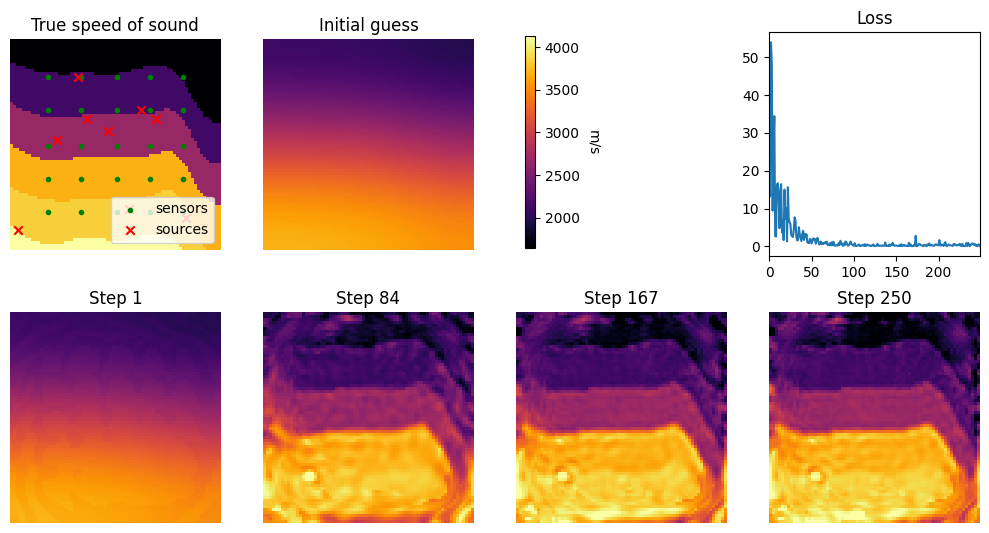

In [45]:
sos_original = get_sound_speed(params)
true_sos = true_model
vmin = np.amin(true_sos)
vmax = np.amax(true_sos)

fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))

k = 0

recs = jnp.linspace(0, num_steps - 1, 4).astype(jnp.int32)

for row in range(2):
    for col in range(4):
        if k == 0:
            axes[row, col].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].scatter(
                sensors_positions[1],
                sensors_positions[0],
                c="g",
                marker=".",
                label="sensors",
            )
            axes[row, col].scatter(
                source_positions[1],
                source_positions[0],
                c="r",
                marker="x",
                label="sources",
            )
            axes[row, col].legend(loc="lower right")
            axes[row, col].set_title("True speed of sound")
            axes[row, col].set_axis_off()
        elif k == 1:
            im_original = axes[row, col].imshow(sos_original, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Initial guess")
            
            cbar_ax = fig.add_axes([0.53, 0.54, 0.01, 0.385])
            cbar = plt.colorbar(im_original, cax=cbar_ax)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('m/s', rotation=270)
        elif k == 2:
            axes[row, col].set_axis_off()
        elif k == 3:
            axes[row, col].plot(losshistory)
            axes[row, col].set_title("Loss")
            #axes[row, col].set_xticks([], [])
            axes[row, col].margins(x=0)
        else:
            axes[row, col].imshow(reconstructions[recs[k - 4]], cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Step {}".format(recs[k - 4] + 1))
        k += 1

# Scale bar
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm
# fontprops = fm.FontProperties(size=12)
# scalebar = AnchoredSizeBar(
#     axes[-1, -1].transData,
#     100, '1 cm', 'lower right', 
#     pad=0.3,
#     color='white',
#     frameon=False,
#     size_vertical=2,
#     fontproperties=fontprops)
# axes[-1, -1].add_artist(scalebar)
        
fig.tight_layout()
plt.show()

# plt.savefig('fwi.pdf')

In [46]:
# save only the final model as well as the source and sensor positions



np.savez(
    "fwi_results_{}.npz".format(file_name),
    final_model=reconstructions[-1],
    source_positions=source_positions,
    sensors_positions=sensors_positions,
    true_model=true_model,
    losshistory=losshistory,
    reconstructions=reconstructions,
    blurred_model=blurred_model,
    homogenous_model=homogenous_model,
    params=params,
    l1_loss=loss_l1,
    l2_loss=loss_l2,
    nRER=singular_loss
)
